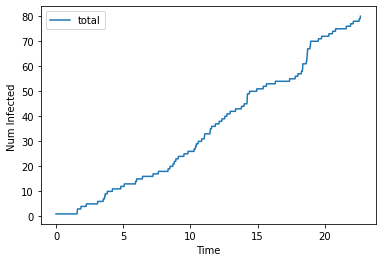

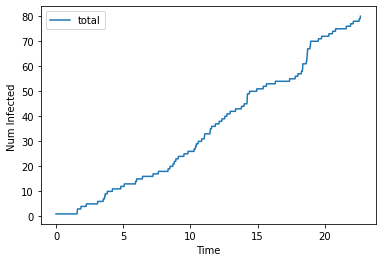

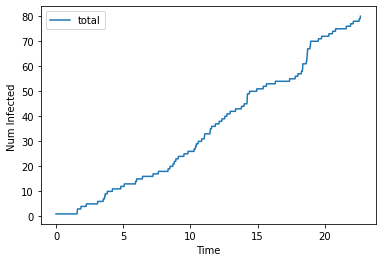

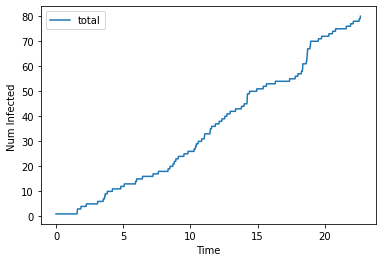

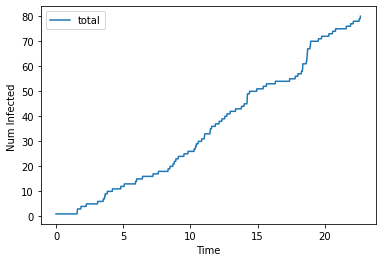

In [1]:
from numpy import zeros, arange, sqrt, array , pi
from random import random , uniform 
from pylab import plot , xlabel , ylabel , legend , figure

#================================================================================
# Scene set up 
#================================================================================
w = 50  # box width
# scene = canvas(width = 10*w, height = 10*w, center = vector(w/2, w/2, 0), range = 0.6*w, fov = 0.01,
#                userzoom = False, autoscale = False, userspin = False)
# # box
# box(pos=vector(0,w/2,0), size=vector(1,w,1), color=color.red)
# box(pos=vector(w,w/2,0), size=vector(1,w,1), color=color.red)
# box(pos=vector(w/2,w,0), size=vector(w,1,1), color=color.red)
# box(pos=vector(w/2,0,0), size=vector(w,1,1), color=color.red)

#================================================================================
# Buttons
#================================================================================

# Temperature slider
def adjustTemp():
    global T0
    tempSliderReadout.text = tempSlider.value
    T0 = tempSlider.value

#================================================================================
# Compute forces, potential energy and radial distribution function
#================================================================================

def force(x,y,rdf):
    
    Fx = zeros(N, float)   # x component of net force on each atom
    Fy = zeros(N, float)   # y component of net force on each atom
    func = rdf[:]          # radial distribution function
    U = 0                  # reinitialize total potential energy
    Fwall = 0              # reinitialize total force on walls    
    for i in range(N):

        # collision with walls
        if x[i] < 0.5:
            Fx[i] += k*(0.5 - x[i])
            Fwall += abs(k*(0.5 - x[i]))
            U += 0.5*k*(0.5 - x[i])*(0.5 - x[i])
        elif x[i] > (w - 0.5):
            Fx[i] += k*(w - 0.5 - x[i])
            Fwall += abs(k*(w - 0.5-x[i]))
            U += 0.5*k*(w - 0.5 - x[i])*(w - 0.5 - x[i])
        if y[i] < 0.5:
            Fy[i] += k*(0.5 - y[i])
            Fwall += abs(k*(0.5 - y[i]))
            U += k*(0.5 - y[i])*(0.5 - y[i])
        elif y[i] > (w - 0.5):
            Fy[i] += k*(w - 0.5 - y[i])
            Fwall += abs(k*(w - 0.5 - y[i]))
            U += k*(w - 0.5 - y[i])*(w - 0.5 - y[i])
        
        # Lennard-Jones interaction
        for j in range(i+1, N):
            deltax = x[j] - x[i]
            deltay = y[j] - y[i]
            Rij = sqrt(deltax*deltax + deltay*deltay)
            
            # radial distribution function
            nbin = int(Rij/dr)
            if nbin == 0:
                func[nbin] = 0
            else:
                func[nbin] += 1/(2*pi*nbin*dr)

            # if atoms within cutoff, compute LJ force
            if Rij <= cutoff:
               
                # potential energy
                U += sigmaTwelfth/Rij**12 - sigmaSixth/Rij**6

                # force
                Fijx = (-12*ljTwelfth/Rij**14 + 6*ljSixth/Rij**8)*(x[j] - x[i])
                Fijy = (-12*ljTwelfth/Rij**14 + 6*ljSixth/Rij**8)*(y[j] - y[i])
            
                # net forces
                Fx[i] += Fijx
                Fy[i] += Fijy
                Fx[j] += -Fijx
                Fy[j] += -Fijy
    
    return Fx,Fy,4*epsilon*U, func

#================================================================================
# Normalize radial distribution function
#================================================================================

def normalize(rdf):
    
    func = rdf[:]
    # normalize function using Trapezoid Rule
    integral = 0.5*dr*(func[0] + 2*sum(func[0:numbin-2]) + func[numbin-1])
    
    return func*w**2/(N*integral)

#================================================================================
# Tells us if the two molecules have collided 
#================================================================================

def collide(i,j):
    deltax = x[j] - x[i]
    deltay = y[j] - y[i]
    Rij = sqrt(deltax*deltax + deltay*deltay)

    if Rij <= radiusVal * 2 :
        return True 
    return False 

#================================================================================
# Simulation parameters
#================================================================================
N = 80                                # number of atoms
dt = 0.02                             # timestep
m = 1.0                               # mass
sigma = 3                             # LJ radius
sigmaSixth = sigma**6                 # sigma^6
sigmaTwelfth = sigmaSixth**2          # sigma^12
epsilon = 1.0                         # LJ well depth
ljSixth = 4*epsilon*sigmaSixth        # 4*epsilon*sigma**6
ljTwelfth = 4*epsilon*sigmaTwelfth    # 4*epsilon*sigma**12
k = 50                                # stiffness of the walls
T0 = 1.0                              # setpoint temperature
nstemp = 50                           # number of time steps before velocity rescaling
nsgraph = 1000                        # number of time steps before graph output and rdf normalization
cutoff = 3*sigma                      # cutoff distance for force calculation
totalInfectedNum = 0
maskInfectedNum = 0
noMaskInfectedNum = 0
immunoInfectedNum = 0
K = 0




#================================================================================
# Initialization
#================================================================================

# arrays for position and velocity
x = zeros(N, float)
y = zeros(N, float)  
vx = array([0.5 - random() for i in range(N)], float)
vy = array([0.5 - random() for i in range(N)], float)
vxmid = zeros(N,float)
vymid = zeros(N,float)

# radial distribution function
dr = 0.1*sigma                        # bin width
numbin = 2*int(w/dr)                  # number of bins
rdf = zeros(numbin, float)            # initialize to zeros
rbins = arange(0,dr*numbin,dr)        # r values for each bin

        
# atoms
ball = []
infected = zeros(N, float)
infectedProb = [] 
typeToInfected = [[0,.33], # mask wearer 
                [.33,.67], # non mask wearer 
                [.67,1]] #immunocompromised
typeOfPerson = zeros(N, float)

# initial atom spacing
dx = w/(int(sqrt(N)) + 1)
dy = w/(int(sqrt(N)) + 1)
x0 = 0.5*dx
y0 = 0.5*dy

#initalization 
radiusVal = sigma*2**(1/6)/2

# initialize positions of atoms
for i in range(N):
    x[i] = x0
    y[i] = y0

    # determine the type of person 
    typeOfP = (int) (100 * random())

    #based on type of person color the molecule accordingly 
    if typeOfP <= 60 : 
        #mask wearer
        typeOfPerson[i] = 0
        #ball.append(sphere(pos=vector(x0,y0,0), radius = radiusVal, color=color.white))
        lowerBound = typeToInfected[0][0]
        upperBound = typeToInfected[0][1]
    elif typeOfP <= 90 : 
        #non mask wearer 
        typeOfPerson[i] = 1
        #ball.append(sphere(pos=vector(x0,y0,0), radius = radiusVal, color=color.blue))
        lowerBound = typeToInfected[1][0]
        upperBound = typeToInfected[1][1]
    else :
        #immununiocompromised
        typeOfPerson[i] = 2
        #ball.append(sphere(pos=vector(x0,y0,0), radius = radiusVal, color=color.green))
        lowerBound = typeToInfected[2][0]
        upperBound = typeToInfected[2][1]


    # based on the type of person determine the chance that they will get infected 
    infectedProbVal = uniform (lowerBound , upperBound)
    infectedProb.append(1)

    
    
    
    
    
    x0 += dx
    if x0 > w:
        x0 = 0.5*dx
        y0 += dy

t = 0          # Initialize time
counter = 0    # Initialize number of time steps

# Select random molecule to be infected 
rand = (int) (random() * len(infected))


# Color the random molecule red
infected[rand] = 1
totalInfectedNum = totalInfectedNum + 1  
#ball[rand].color = color.red

if typeOfPerson[rand] == 1:
    noMaskInfectedNum += 1 
elif typeOfPerson[rand] == 0:
    maskInfectedNum += 1
elif typeOfPerson[rand] == 2:
    immunoInfectedNum += 1



# Perform a half step
Fx,Fy,U, rdf = force(x,y,rdf)
vxmid = vx + 0.5*dt*Fx/m
vymid = vy + 0.5*dt*Fy/m
K = 0.5*m*sum(vx**2 + vy**2)
K = 0.5*m*sum(vx**2 + vy**2)
T = K/N        

#================================================================================
# Output
#================================================================================

#graphing Arrays 
timeVals = []
totalInfectedVals = []
nomaskVals = []
maskVals = []
immunoVals = []

#================================================================================        
# Main simulation loop
#================================================================================

running = True
for d in range(5):

  while totalInfectedNum != N :
      
      #rate(5/dt)
      #rate(500)
      
      if running:
          
          # Verlet algorithm
          x += vxmid*dt
          y += vymid*dt
          Fx, Fy, U, rdf = force(x,y,rdf)  # calculate forces,potential energy
          vx = vxmid + 0.5*Fx/m*dt
          vy = vymid + 0.5*Fy/m*dt
          vxmid += Fx/m*dt
          vymid += Fy/m*dt
          
          K = 0.5*m*sum(vx*vx + vy*vy) # kinetic energy
          T = K/N                      # temperature

          # Update atom positions
          for i in range(N):
              #ball[i].pos = vector(x[i], y[i], 0)
              
              # set other mols to be infected if atom is infected
              if infected[i] == 1:
                  for j in range(N):
                      prob_rand = random()
                      infectedProbVal = infectedProb[j]
                      if j != i and infected[j] == 0 and prob_rand < infectedProbVal:
                          if collide(i,j):
                              #in this situation they have "hit"
                              if typeOfPerson[j] == 1:
                                  noMaskInfectedNum += 1 
                              elif typeOfPerson[j] == 0:
                                  maskInfectedNum += 1
                              elif typeOfPerson[j] == 2:
                                  immunoInfectedNum += 1

                              #ball[j].color = color.red
                              infected[j] = 1
                              totalInfectedNum = totalInfectedNum + 1

                              


          if counter % nsgraph == 0:
              rdf = normalize(rdf)                # normalize radial distribution function
              #radialdistplot.delete()             # plot radial distribution function
              for i in range(numbin):
                  #radialdistplot.plot(i*dr/sigma, rdf[i])
                  rdf = zeros(numbin, float)          # reinitialize radial distribution function  
          
          # Thermostat
          if counter % nstemp == 0 and counter > 0:
              if T == 0:
                  for i in range(N):
                      vxmid[i] = 1.0 - random()
                      vymid[i] = 1.0 - random()
              else:
                  gamma = sqrt(T0/T)
                  vxmid *= gamma
                  vymid *= gamma
          
          #plot 
          timeVals.append(t)
          totalInfectedVals.append(totalInfectedNum)
          maskVals.append(maskInfectedNum)
          nomaskVals.append(noMaskInfectedNum)
          immunoVals.append(immunoInfectedNum)
        
          counter += 1 # number of timesteps
          t += dt      # increase time     

  figure(d)
  plot(timeVals, totalInfectedVals, label="total" ) 
  #plot(timeVals, maskVals , label="mask") 
  #plot(timeVals, nomaskVals , label="no mask") 
  #plot(timeVals, immunoVals , label="immunocompromised") 
  xlabel("Time")
  ylabel("Num Infected ")
  legend()

